### DQN
- 간단한 게임 환경에서 스스로 성장하는 DQN

In [3]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

#### 하이퍼파라미터

In [4]:
# 하이퍼파라미터
EPISODES = 50    # 애피소드 반복횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

#### DQN 에이전트

In [5]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0
        self.memory = deque(maxlen=10000)

    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### 학습 준비
- gym을 이용하여 CartPole-v0환경을 준비하고 앞서 만들어둔 DQNAgent를 agent로 인스턴스화


In [6]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


#### 학습 시작

In [9]:
for e in range(1, EPISODES+1):
    state = env.reset()
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


ValueError: expected sequence of length 4 at dim 2 (got 0)

- 나중에 다시!

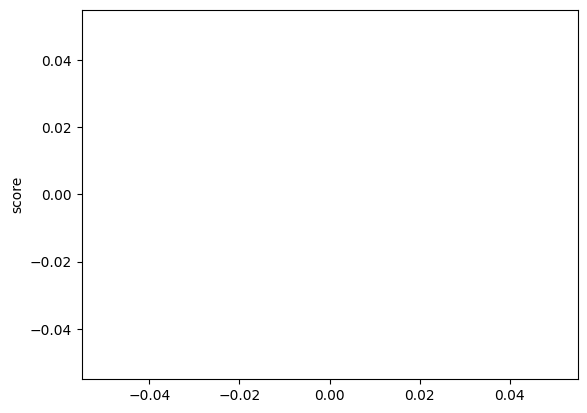

In [10]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()